In [6]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

from parse_data import *

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

In [7]:
#Set to False if no subsampling, else set to the desired number for subsample results:
subsampling = False
#subsampling = 100

output_data_path = 'result_data/'

reference_data_path  = '../reference_data/'

#Outcomment all but the resolution desired:
if subsampling == False:
    resultpath = '../output_full_dataset/'
else:
    resultpath = f'../downsampling_results/output_{subsampling}X/1000_genomes_results/'



## Create one conversion function (1-field, 2-field, P group, NetMHCseq group)

In [8]:
def flatten(a):
    return [item for sublist in a for item in sublist if item != []]

In [9]:
#Make function for conversion, to be used in this run of the notebook:
p_group_dict = make_p_group_dict()
e_group_dict = make_e_group_dict()

def convert_allele(allele, resolution = 'two_field'):

    """
    input:
    allele (str): An allele in the format (A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3} to be converted.
    resolution:   the resolution, with which the allele is converted to

    """
    if resolution == "one_field":
        converted_allele = convert_to_one_field(allele)
    
    elif resolution == "two_field":
        converted_allele = convert_to_two_field(allele)
        
    elif resolution == "p_group":
        converted_allele = convert_to_p_group(allele, p_group_dict=p_group_dict)
    
    elif resolution == "e_group":
        converted_allele = convert_to_e_group(allele, e_group_dict=e_group_dict, p_group_dict=p_group_dict)
            
    else:
        print("A conversion mistake happend. Please specify a correct conversion type.")
        converted_allele = None
        
    return converted_allele      

# Load Typing Results by HLA Typing tools:

## Kourami
Save both single and ambiguous results

In [10]:
kourami_result_filepath = resultpath + 'kourami/'

kourami_log_filepath = resultpath + 'kourami_results_from_logfiles/'

kourami_files = list()
kourami_logfiles = list()

#Initalize result dict for single guess and for multiple typing
kourami_results = dict()
kourami_results_ambiguous = dict()


for (dirpath, dirnames, filenames) in walk(kourami_result_filepath):
    kourami_files.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(kourami_log_filepath):
    kourami_logfiles.extend(filenames)
    

for filename in kourami_files:
    #Don't include the performance logs
    if filename.endswith('.txt'):
        
        #If file is not empty:
        if os.stat(kourami_result_filepath + filename).st_size != 0:
            temp_result_dict = dict()
            temp_result_dict_ambiguous = dict()
    
            with open(kourami_result_filepath + filename, 'r') as infile:

                for line in infile:
                    #Find the first match / allele prediction
                    allele_searcher = re.search(r"(A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3}", line)
                    
                    #Find all allele predictions (ambiguous). ?: is required for non-capturing groups
                    allele_searcher_ambiguous = re.findall(r"(?:A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3}", line)
                    
                    if allele_searcher is not None:                        
                        found_allele = allele_searcher.group(0)
                        
                        gene = re.search(r"(A|B|C|DRB1|DQB1)", found_allele).group(0)
                        
                        #Convert alleles to right resolution:
                        pred_converted = convert_allele(found_allele)
                        #pred_converted = found_allele
                        if pred_converted != convert_to_two_field(found_allele):
                            print(filename)

                        allele_searcher_ambiguous_converted = [convert_allele(i) for i in allele_searcher_ambiguous]

                        #Add to list of predictions for this sample
                        if gene not in temp_result_dict.keys():
                            temp_result_dict[gene] = [[pred_converted]]
                            temp_result_dict_ambiguous[gene] = [allele_searcher_ambiguous_converted]
                        else:
                            temp_result_dict[gene] += [[pred_converted]]
                            temp_result_dict_ambiguous[gene] += [allele_searcher_ambiguous_converted]

            #Add sample prediction to dict
            kourami_results[filename[:-4]] = temp_result_dict
            kourami_results_ambiguous[filename[:-4]] = temp_result_dict_ambiguous
            
            
        #If file is empty, add an empty dict.
        else:
            kourami_results[filename[:-4]] = dict()
            kourami_results_ambiguous[filename[:-4]] = dict()
            #print("Unable to load results for sample" + filename[:-4] + ". No prediction added")                           
                
#kourami_results

## HLA-LA

In [11]:
hla_la_result_filepath = resultpath + 'hla-la/'

hla_la_files = []
for (dirpath, dirnames, filenames) in walk(hla_la_result_filepath):
    hla_la_files.extend(filenames)
    
#print(hla_la_files)


hla_la_results = dict()

for filename in hla_la_files:
    if filename.endswith('.txt'):
        temp_results_object = pd.read_csv(hla_la_result_filepath + filename, sep = "\t")['Allele']
        temp_results = [i for i in temp_results_object if i.startswith(('A', 'B', 'C', 'DRB1', 'DQB1'))]
        
        
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred          
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]

        
        hla_la_results[filename[:-4]] = temp_result_dict


#hla_la_results

## Optitype

In [12]:
optitype_result_filepath = resultpath + 'optitype/'

optitype_files = []
for (dirpath, dirnames, filenames) in walk(optitype_result_filepath):
    optitype_files.extend(filenames)
    
#print(optitype_files)


optitype_results = dict()

for filename in optitype_files:
    
    #Check for right file, and that the file is not empty
    if (filename.endswith('.txt')) and (os.stat(optitype_result_filepath + filename).st_size != 0):
        temp_results_raw = list(pd.read_csv(optitype_result_filepath + filename, sep = "\t").iloc[0])[1:7]

        temp_results = [i for i in temp_results_raw if isinstance(i,str)]
  
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]
      
        optitype_results[filename[:-4]] = temp_result_dict
 
    #Add empty entry for empty file
    elif (filename.endswith('.txt')) and (os.stat(optitype_result_filepath + filename).st_size == 0):
        optitype_results[filename[:-4]] = dict()
        
#optitype_results

## Hisatgenotype

In [13]:
hisatgenotype_result_filepath = resultpath + 'hisatgenotype/'

hisatgenotype_files = []
for (dirpath, dirnames, filenames) in walk(hisatgenotype_result_filepath):
    hisatgenotype_files.extend(filenames)
    
#print(hisatgenotype_files)

#Save two predictions. One, with one guess per allele and one with the full prediction
hisatgenotype_results = dict()

for filename in hisatgenotype_files:
    if filename.endswith('.txt'):
    
        hisatgenotype_resultlist = list()
        
        hisatgenotype_resultlist_ambiguous = list()
      
        with open(hisatgenotype_result_filepath + filename) as infile:
            for line in infile:
                result = re.match(r'^\t+(1|2)\sranked (A|B|C|DRB1|DQB1)',line)
            
                if result is not None:
                    hisatgenotype_resultlist.append(line.split()[2])              
                     
            #Duplicate prediction for an allele in case of homologous case, so that each gene has two predictions.
            #In a homologous case, both result dicts only have one prediction and both needs an update.
            for allele in ['A', 'B', 'C', 'DRB1', 'DQB1']:
                allele_list = [pred for pred in hisatgenotype_resultlist if pred.startswith(allele)]

                if len(allele_list) == 1:
                    hisatgenotype_resultlist.append(allele_list[0])
                    hisatgenotype_resultlist.sort()

            temp_results = hisatgenotype_resultlist
            
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]


        hisatgenotype_results[filename[:-4]] = temp_result_dict
                
#hisatgenotype_results           
        

## STC-seq

In [14]:
stc_seq_result_filepath = resultpath + 'stc-seq/'

stc_seq_files = []
for (dirpath, dirnames, filenames) in walk(stc_seq_result_filepath):
    stc_seq_files.extend(filenames)
    
#print(stc_seq_files)

stc_seq_results = dict()

for filename in stc_seq_files:
    if filename.endswith('.txt'):
        
        #Get raw results as lists
        stc_df = pd.read_csv(stc_seq_result_filepath + filename, sep = "\t").reset_index()
        stc_df.columns = stc_df.iloc[0]
        stc_list = list(stc_df[stc_df['Locus'].isin(['A', 'B', 'C','DRB1', 'DQB1'])]['Genotype'])
        stc_seq_alt_list = list(stc_df[stc_df['Locus'].isin(['A', 'B', 'C','DRB1', 'DQB1'])]['Alternative_genotype'].dropna())

        #Format results for single prediction
        temp_results =  flatten([i.split(',') for i in stc_list])
        
        
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)

            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]

                
        #Add predictions to dicts
        stc_seq_results[filename[:-4]] = temp_result_dict

#stc_seq_results

## Depth analysis

In [15]:
#load data
depth_filepath = '../output_full_dataset/depth/'

depth_files = []
for (dirpath, dirnames, filenames) in walk(depth_filepath):

    depth_files.extend(filenames)

depth_results = dict()

for filename in depth_files:
    
    if filename.endswith('.depth.mosdepth.summary.txt'):
        temp_results = pd.read_csv(depth_filepath + filename, sep='\t')
        
        temp_results.set_index('chrom', inplace=True)
        
        mean_region_depth = temp_results.loc['total_region', 'mean']
        depth_results[filename[0:7]] = mean_region_depth

In [16]:
depth_df = pd.DataFrame(depth_results, index=['mean_depth']).T
depth_df.to_csv('result_data/sample_depth.csv')

# Load Gold standard data

In [17]:
#Load data
MG_exome_merged_df = pd.read_pickle(output_data_path + "MG_exome_merged_df.pkl")

gs_two_field_df = pd.read_pickle(output_data_path + "gs_two_field_df.pkl")

gold_standard_id_list = list(MG_exome_merged_df.index)

#Only pick the 221 chosen samples, if this is for downsampling:
if subsampling != False:
    gold_standard_id_list = list(kourami_results.keys())
    
MG_exome_merged_df = MG_exome_merged_df.loc[gold_standard_id_list]

gs_two_field_df = gs_two_field_df.loc[gold_standard_id_list]

# Chose which dataframe should be the gold standard (pick between resolutions)
gold_standard_df = gs_two_field_df

## Allele diversity in the tools and the 1000G dataset

In [18]:
tool_gene_count = dict()

tool_gene_count['1000G reference'] = dict()
for gene in gs_two_field_df.columns:
    tool_gene_count['1000G reference'][gene] = list()
    for patient in gs_two_field_df[gene].values:
        for alleles in patient:
            for allele in alleles:
                tool_gene_count['1000G reference'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Kourami'] = dict()
check = dict()
for patient, typing in kourami_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['Kourami'][gene] = list()
            check[gene] = ''   

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['Kourami'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['HLA-LA'] = dict()
check = dict()
for patient, typing in hla_la_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['HLA-LA'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['HLA-LA'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['HISAT-genotype'] = dict()
check = dict()
for patient, typing in hisatgenotype_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['HISAT-genotype'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['HISAT-genotype'][gene].append(convert_allele(allele=allele, resolution='p_group'))


tool_gene_count['STC-Seq'] = dict()
check = dict()
for patient, typing in stc_seq_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['STC-Seq'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['STC-Seq'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Optitype'] = dict()
check = dict()
for patient, typing in optitype_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['Optitype'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['Optitype'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Optitype']['DRB1'] = []
tool_gene_count['Optitype']['DQB1'] = []

# for method, typing in tool_gene_count.items():
#     for loci, alleles in typing.items():
#         print(f'{method}\t{loci}\t{len(alleles)}')

# loci_counter_dict = dict()
# for loci in ['A', 'B', 'C', 'DRB1', 'DQB1']:
#     loci_counter_dict[loci] = {method : len(set(call_list[loci])) for method, call_list in tool_gene_count.items()}

method_counter_dict = dict()
for tool in tool_gene_count:
    method_counter_dict[tool] = {loci : len(set(call_list)) for loci, call_list in tool_gene_count[tool].items()}

In [19]:
import seaborn as sns 
grey_list_hex = ['808080']
grey_rgb_tuple = [tuple(int(h[i:i+2], 16)/256 for i in (0, 2, 4)) for h in grey_list_hex]

palette_list = grey_rgb_tuple + list(sns.color_palette("colorblind"))

def make_plot_from_allele_list(title):

    fig, ax = plt.subplots(1, 1, figsize=(16,12))

    df = pd.DataFrame(method_counter_dict)
    df.plot(kind='bar', color = palette_list, ax=ax)  
   
    ax.legend()

    def autolabel(rects, y_height):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.1f}'.format(height, ),
                        xy=(rect.get_x() + rect.get_width() / 2, y_height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        color="black", size = 18, weight =400)
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)       
    
    ax.tick_params(axis="y", labelsize=16)
    ax.tick_params(axis='x', labelsize=16, rotation=0)

    # # Or if you want different settings for the grids:
    ax.grid(axis = 'y')
    ax.set_ylim(0,df.max().max()+25)

    ax.legend(loc='best', prop={'size': 18})

    ax.set_title(title, size = 20)
    ax.set_ylabel('Unique HLA allele calls in P group resolution', size = 20)
    ax.set_xlabel('HLA locus', size = 20)

    plt.tight_layout()
    
    return plt, df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


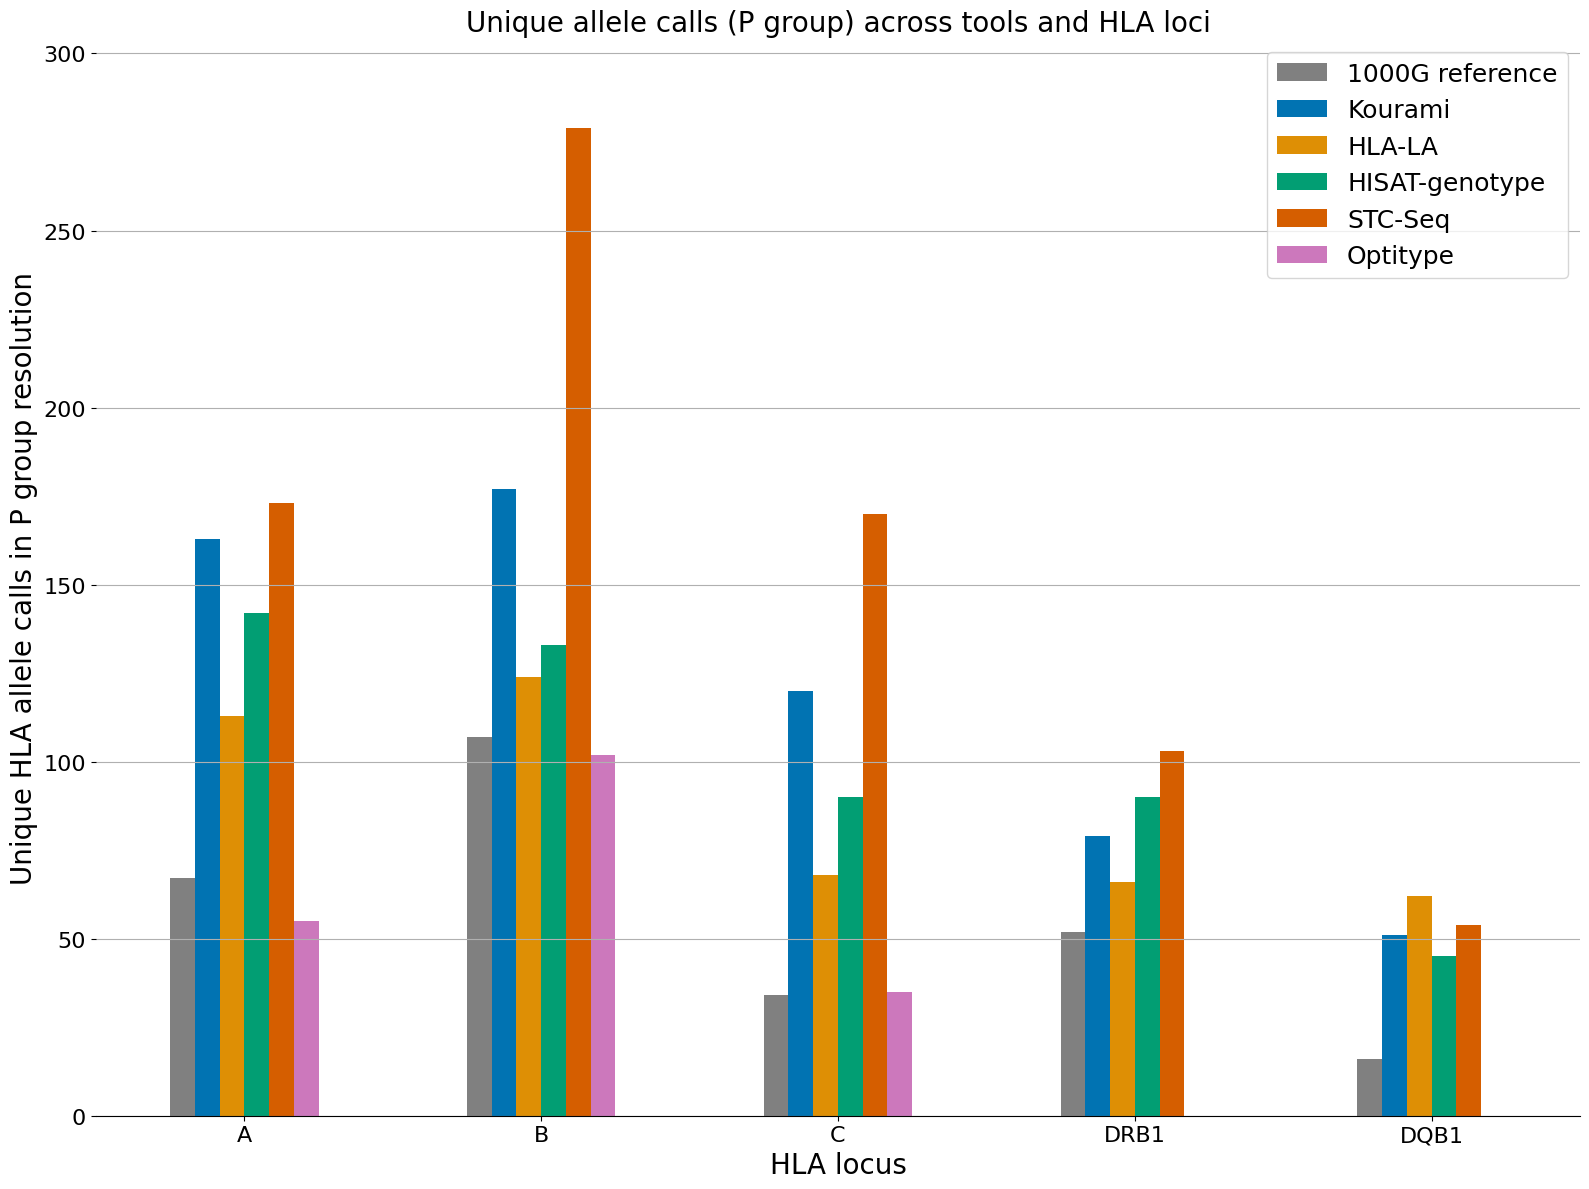

In [20]:
if subsampling == False:
    plot, unique_alleles_df = make_plot_from_allele_list('Unique allele calls (P group) across tools and HLA loci')
    plot.savefig('plots/unique_allele_calls.eps')
    unique_alleles_df.to_csv('result_data/unique_allele_calls_full_dataset.csv')
else:
    plot, unique_alleles_df = make_plot_from_allele_list(f'Unique allele calls across HLA typing tools for 230 WES samples with a coverage of {subsampling}X')
    plot.savefig(f'plots/unique_allele_calls_subsampling_{subsampling}X.tiff')
    unique_alleles_df.to_csv(f'result_data/unique_allele_calls_{subsampling}X.csv')

# Typing accuracy and Call rate of the tools

In [21]:
gold_standard_df = gs_two_field_df
gold_standard_df.head()

,A,B,C,DRB1,DQB1
id,,,,,
NA06985,"[[A*03:01], [A*02:01]]","[[B*07:02], [B*57:01]]","[[C*07:02], [C*06:02]]","[[DRB1*15:01], [DRB1*15:01]]","[[DQB1*06:02], [DQB1*06:02]]"
NA06986,"[[A*03:01], [A*32:01]]","[[B*44:03], [B*44:03]]","[[C*04:01], [C*16:01]]","[[DRB1*07:01], [DRB1*07:01]]","[[DQB1*02:02], [DQB1*02:02]]"
NA06994,"[[A*02:01], [A*32:01]]","[[B*40:02], [B*08:01]]","[[C*02:02], [C*07:06, C*07:01]]","[[DRB1*01:01], [DRB1*04:04]]","[[DQB1*05:01], [DQB1*03:02]]"
NA07000,"[[A*02:01], [A*68:01]]","[[B*44:02], [B*40:01]]","[[C*03:04, C*03:03], [C*07:04]]","[[DRB1*03:01], [DRB1*11:01]]","[[DQB1*02:01], [DQB1*03:01]]"
NA07037,"[[A*30:01], [A*31:01]]","[[B*15:10], [B*40:01]]","[[C*03:04], [C*03:04]]","[[DRB1*04:04], [DRB1*13:02]]","[[DQB1*03:02], [DQB1*06:04]]"


In [22]:
def validate_call(correct_alleles, predicted_alleles, resolution):

    #Start by converting the alleles to the correct resolution
    correct_call_1 = {convert_allele(allele, resolution=resolution) for allele in correct_alleles[0]}
    correct_call_2 = {convert_allele(allele, resolution=resolution) for allele in correct_alleles[1]}
    correct_call = [list(correct_call_1), list(correct_call_2)]
    
    if predicted_alleles == '':
        num_correct_hits = 0
        pred_call = predicted_alleles
        return num_correct_hits, correct_call, pred_call

    pred_1 = {convert_allele(predicted_alleles[0][0], resolution=resolution)}
    pred_2 = {convert_allele(predicted_alleles[1][0], resolution=resolution)}
    pred_call = [list(pred_1), list(pred_2)]

    try:
        correct_0_pred_0 = list(correct_call_1.intersection(pred_1))
        correct_1_pred_1  = list(correct_call_2.intersection(pred_2))

        option_1 = [correct_0_pred_0, correct_1_pred_1]

        correct_0_pred_1  = list(correct_call_1.intersection(pred_2))
        correct_1_pred_0  = list(correct_call_2.intersection(pred_1))

        option_2 = [correct_0_pred_1, correct_1_pred_0]

        hits_1 = len([i for i in option_1 if i != []])
        hits_2 = len([i for i in option_2 if i != []])

        num_correct_hits = max(hits_1,hits_2)
        
    except KeyError as error:
        num_correct_hits = 0

    return num_correct_hits, correct_call, pred_call

#Get the number of predictions from a tool for a specific allele for a specific subject (2 or 0)
def get_count(tool_prediction, locus, subject):
    try:
        pred = tool_prediction[subject][locus]
        return len(pred)
    except KeyError as error:
        return 0

In [23]:
typing_results_dict = {
    'Kourami' : kourami_results,
    'HLA-LA' : hla_la_results,
    'Optitype' : optitype_results,
    'Hisatgenotype' : hisatgenotype_results,
    'STC-seq' : stc_seq_results,
}

def validate_typing(typing_results_dict, gold_standard_df, subject_id_list, resolution):
    results_dict = dict()
    full_typing_results_dict = dict()

    #Loop over subjects, loci and tools
    for tool in typing_results_dict:
        results_dict[tool] = dict()
        full_typing_results_dict[tool] = dict()
        
        for locus in gold_standard_df.columns:
            results_dict[tool][locus] = dict()
            results_dict[tool][locus]['count'] = 0
            results_dict[tool][locus]['score'] = 0

            full_typing_results_dict[tool][locus] = dict()

            #Find counts of calls and correct calls
            for subject in subject_id_list:
                predicted_alleles = ''
                #If typing exists:
                if subject in typing_results_dict[tool]:
                    if locus in typing_results_dict[tool][subject]:
                        #Count number of total calls:
                        results_dict[tool][locus]['count'] += get_count(typing_results_dict[tool], locus, subject)
                    
                        #check whether it is valid.
                        predicted_alleles = typing_results_dict[tool][subject][locus]
                

                correct_alleles_list = gold_standard_df.loc[subject, locus]
                num_correct_hits, correct_call, pred_call = validate_call(correct_alleles_list, predicted_alleles, resolution)

                full_typing_results_dict[tool][locus][subject] = dict()
                full_typing_results_dict[tool][locus][subject]['reference'] = correct_call
                full_typing_results_dict[tool][locus][subject]['prediction'] = pred_call
                full_typing_results_dict[tool][locus][subject]['miscalls'] = 2-num_correct_hits
                
                results_dict[tool][locus]['score'] += num_correct_hits


            

        #Add entries for all class I, class II and all alleles
        results_dict[tool]['HLA-I'] = dict()
        results_dict[tool]['HLA-II'] = dict()
        results_dict[tool]['Total'] = dict() 

        results_dict[tool]['HLA-I']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['A', 'B', 'C']]) 
        results_dict[tool]['HLA-II']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['DRB1', 'DQB1']]) 
        results_dict[tool]['Total']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['HLA-I', 'HLA-II']]) 

        results_dict[tool]['HLA-I']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['A', 'B', 'C']]) 
        results_dict[tool]['HLA-II']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['DRB1', 'DQB1']]) 
        results_dict[tool]['Total']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['HLA-I', 'HLA-II']]) 


        #Find total counts and calculate call rate and typing accuracy
        for locus in results_dict[tool]:
            if locus in ['A', 'B', 'C', 'DRB1', 'DQB1']:
                multiplier = 1
            elif locus == 'HLA-I':
                multiplier = 3
            elif locus == 'HLA-II':
                multiplier = 2
            elif locus == 'Total':
                multiplier = 5

            total_correct_calls = multiplier * len(gold_standard_df[gold_standard_df.index.isin(subject_id_list)]) * 2
            results_dict[tool][locus]['call_rate'] = results_dict[tool][locus]['count'] * 100  / total_correct_calls
            results_dict[tool][locus]['typing_accuracy'] = results_dict[tool][locus]['score'] * 100 / total_correct_calls


    return results_dict, full_typing_results_dict

In [24]:
#Loop over typing resolutions 
rename_resolutions = {
    'one_field' : '1-field',
    'e_group' : 'pseudosequence',
    'p_group' : 'P group',
    'two_field' : '2-field',
}


four_resolutions_results = dict()
full_typing_results_dict = dict()
for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
    four_resolutions_results[rename_resolutions[resolution]], full_typing_results_dict[rename_resolutions[resolution]] = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=gold_standard_id_list, resolution=resolution)

#four_resolutions_results

# Save results

In [25]:
#Overall result dataframe:

import json

if subsampling == False:
    filename = f'{output_data_path}results_full_dataset.json'
else:
    filename = f'{output_data_path}results_{subsampling}.json'

with open(filename, 'w', encoding='utf-8') as f:
    json.dump(four_resolutions_results, f, ensure_ascii=False, indent=4)

In [26]:
#Save miscalls
if subsampling == False:
    filename = f'{output_data_path}full_typing_results_full_dataset.json'
else:
    filename = f'{output_data_path}full_typing_results_{subsampling}.json'

with open(filename, 'w', encoding='utf-8') as f:
    json.dump(full_typing_results_dict, f, ensure_ascii=False, indent=4)

# Test impact of subsampling dataset (roboustness to using fewer samples)

In [27]:
def reformat_dict(results_dict):
    #Reformat json structure into pandas Dataframe
    reformatted_dict = dict()
    for resolution, tool_dict in results_dict.items():
        for tool, locus_dict in tool_dict.items():
            for locus, metric_dict in locus_dict.items():
                for metric, value in metric_dict.items():
                    if (tool, resolution) not in reformatted_dict:
                        reformatted_dict[(tool, resolution)] = dict()

                    #Drop count, score and save typing accuracy per resolution
                    if metric == 'typing_accuracy':
                        reformatted_dict[(tool, resolution)][locus] = value
                    elif (metric == 'call_rate'):
                        if (tool, metric) not in reformatted_dict:
                            reformatted_dict[(tool, metric)] = dict()
                        if locus not in reformatted_dict[(tool, metric)]:
                            reformatted_dict[(tool, metric)][locus] = value
        
    results_df = pd.DataFrame(reformatted_dict)


    tool_order = ['Kourami', 'HLA-LA', 'Optitype', 'Hisatgenotype', 'STC-seq']
    metric_order = ['call_rate', '1-field', 'pseudosequence', 'P group', '2-field']

    multi_tuples = []
    for tool in tool_order:
        for metric in metric_order:
            multi_tuples += [(tool, metric)]

    multi_cols = pd.MultiIndex.from_tuples(multi_tuples, names=['Tool', 'Metric'])

    results_df = pd.DataFrame(results_df, columns=multi_cols)
    return results_df

In [28]:
reformat_dict(four_resolutions_results)

Tool      Kourami                                                    HLA-LA  \
Metric  call_rate    1-field pseudosequence    P group    2-field call_rate   
A       96.501809  95.355850      88.661037  85.645356  85.645356     100.0   
B       86.369119  84.800965      79.131484  78.287093  78.287093     100.0   
C       90.470446  89.445115      84.439083  82.689988  82.026538     100.0   
DRB1    99.396864  97.346200      96.501809  96.381182  95.717732     100.0   
DQB1    83.715320  79.131484      76.176116  75.572979  73.944511     100.0   
HLA-I   91.113792  89.867310      84.077201  82.207479  81.986329     100.0   
HLA-II  91.556092  88.238842      86.338963  85.977081  84.831122     100.0   
Total   91.290712  89.215923      84.981906  83.715320  83.124246     100.0   

Tool                                                    Optitype             \
Metric    1-field pseudosequence    P group    2-field call_rate    1-field   
A       99.155609      95.054282  92.762364  92.762364     100.0  99.819059   
B       99.457177      98.130277  97.889023  97.768396     100.0  99.215923   
C       99.638118      97.828709  97.165259  96.622437     100.0  99.698432   
DRB1    98.431846      97.949337  97.889023  97.225573       0.0   0.000000   
DQB1    99.155609      97.104946  95.778046  94.028951       0.0   0.000000   
HLA-I   99.416968      97.004423  95.938882  95.717732     100.0  99.577805   
HLA-II  98.793727      97.527141  96.833534  95.627262       0.0   0.000000   
Total   99.167672      97.213510  96.296743  95.681544      60.0  59.746683   

Tool                                        Hisatgenotype             \
Metric pseudosequence    P group    2-field     call_rate    1-field   
A           99.034982  98.914355  98.914355         100.0  92.943305   
B           98.371532  98.130277  98.009650         100.0  97.828709   
C           99.396864  99.034982  98.492159         100.0  96.863691   
DRB1         0.000000   0.000000   0.000000         100.0  94.451146   
DQB1         0.000000   0.000000   0.000000         100.0  94.933655   
HLA-I       98.934459  98.693205  98.472055         100.0  95.878569   
HLA-II       0.000000   0.000000   0.000000         100.0  94.692400   
Total       59.360676  59.215923  59.083233         100.0  95.404101   

Tool                                           STC-seq             \
Metric pseudosequence    P group    2-field  call_rate    1-field   
A           87.092883  81.121834  81.001206  70.084439  60.313631   
B           94.089264  93.305187  93.063932  71.170084  57.961399   
C           94.813028  93.003619  92.822678  67.913148  58.624849   
DRB1        90.651387  88.600724  88.299156  77.201448  67.249698   
DQB1        92.460796  89.987937  88.902292  57.901086  52.171291   
HLA-I       91.998392  89.143546  88.962606  69.722557  58.966626   
HLA-II      91.556092  89.294331  88.600724  67.551267  59.710495   
Total       91.821472  89.203860  88.817853  68.854041  59.264174   

Tool                                         
Metric pseudosequence    P group    2-field  
A           54.402895  51.447527  50.844391  
B           48.190591  46.863691  46.381182  
C           50.180941  45.778046  44.511460  
DRB1        63.027744  62.786490  62.484922  
DQB1        49.758745  48.250905  47.225573  
HLA-I       50.924809  48.029755  47.245678  
HLA-II      56.393245  55.518697  54.855247  
Total       53.112183  51.025332  50.289505

In [29]:
idx = pd.IndexSlice

labels1 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq', 'Optitype']
labels2 = ['Kourami', 'HLA-LA', 'Hisatgenotype', 'STC-seq']
textlabels1 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', 'Optitype']
textlabels2 = ['Kourami', 'HLA*LA', 'HISAT-genotype', 'STC-Seq', '']

def make_plot_from_allele_list():

    fig, axs = plt.subplot_mosaic([['A'], ['B']], constrained_layout=True, figsize=(18,12))
    figpanels = ['A', 'B']

    for label, ax in axs.items():

        if label == 'A':
            allele_index = 'HLA-I'
            title = 'HLA Class I alleles (HLA-A, -B and -C)'
        else:
            allele_index = 'HLA-II'
            title = 'HLA Class II alleles (HLA-DRB1 and -DQB1)'

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels1, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels1, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels1, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels1, 'pseudosequence']])
        
            x = np.arange(len(labels1))
            
        else:   
            call_rate = list(results_df.loc[allele_index, idx[labels1, 'call_rate']])
            accuracy_one_field = list(results_df.loc[allele_index, idx[labels1, '1-field']])
            accuracy_two_field = list(results_df.loc[allele_index, idx[labels1, '2-field']])
            accuracy_p_group = list(results_df.loc[allele_index, idx[labels1, 'P group']])
            accuracy_e_group = list(results_df.loc[allele_index, idx[labels1, 'pseudosequence']])
                
            x = np.arange(len(labels1))  # the label locations
    

        width = 0.18  # the width of the bars
        rects1 = ax.bar(x - 10.4*width/5, call_rate, width, label='call rate', color = '#808080')
        rects2 = ax.bar(x - 5*width/5, accuracy_one_field, width, label='1-field accuracy', color = palette_list[0])
        rects3 = ax.bar(x, accuracy_e_group, width, label='Pseudoseq accuracy', color = palette_list[1])
        rects4 = ax.bar(x + 5*width/5, accuracy_p_group, width, label='P group accuracy', color = palette_list[2])
        rects5 = ax.bar(x + 10*width/5, accuracy_two_field, width, label='2-field accuracy', color = palette_list[3])

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('%', size = 22)
        ax.set_xticks(x)
        
        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            ax.set_xticklabels(textlabels2, size = 18)
        else:
            ax.set_xticklabels(textlabels1, size = 18)

        ax.legend()


        def autolabel(rects, y_height):
            """Attach a text label above each bar in *rects*, displaying its height."""
            for rect in rects:
                if (allele_index in ('HLA-II', 'DRB1', 'DQB1')) and (rect.get_x() > 3.5):
                    continue
                else:
                    height = rect.get_height()
                    ax.annotate(f"{format(height, '#.3g')}",
                                xy=(rect.get_x() + rect.get_width() / 2, y_height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', 
                                color="black", size = 16, weight =400)

        autolabel(rects1, 50)
        autolabel(rects2, 40)
        autolabel(rects3, 30)
        autolabel(rects4, 20)
        autolabel(rects5, 10)        
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)       
        
        ax.grid(which='minor', alpha=0.4)
        # Major ticks every 20, minor ticks every 5
        minor_ticks = np.arange(0, 101, 5)

        ax.set_yticks(minor_ticks, minor=True)
        ax.tick_params(axis="y", labelsize=16)


        # Or if you want different settings for the grids:
        ax.grid(axis = 'y')
        ax.set_axisbelow(True)

        if allele_index in ('HLA-II', 'DRB1', 'DQB1'):
            ax.legend(loc='right', prop={'size': 18})
        else:
            ax.get_legend().remove()
        plt.tight_layout()

        #plt.title('HLA typing performance for HLA-A, -B, -C, -DRB1 and DQB1', size = 24)
        #plt.title('HLA typing performance for HLA class II genes (with ensemble)', size = 24)
        ax.set_title(f'HLA typing performance for {title}', size = 22)
        trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
        ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans,
                fontsize=22, va='bottom', fontfamily='serif', weight='bold')
    
    plt.tight_layout()
    
    return plt

In [30]:
# import random

# random.shuffle(gold_standard_id_list)

# sub_gs_list = gold_standard_id_list[0:700]

# subsample_700_results_dict = dict()
# for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
#     subsample_700_results_dict[rename_resolutions[resolution]], miscalls_dict = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=sub_gs_list, resolution=resolution)

# results_df = reformat_dict(subsample_700_results_dict)

# import matplotlib.transforms as mtransforms
# palette_list = list(sns.color_palette("colorblind"))
# fig = make_plot_from_allele_list()
# if subsampling == False:
#     fig.savefig('plots/review_plots/results_full_coverage_700_samples.jpg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


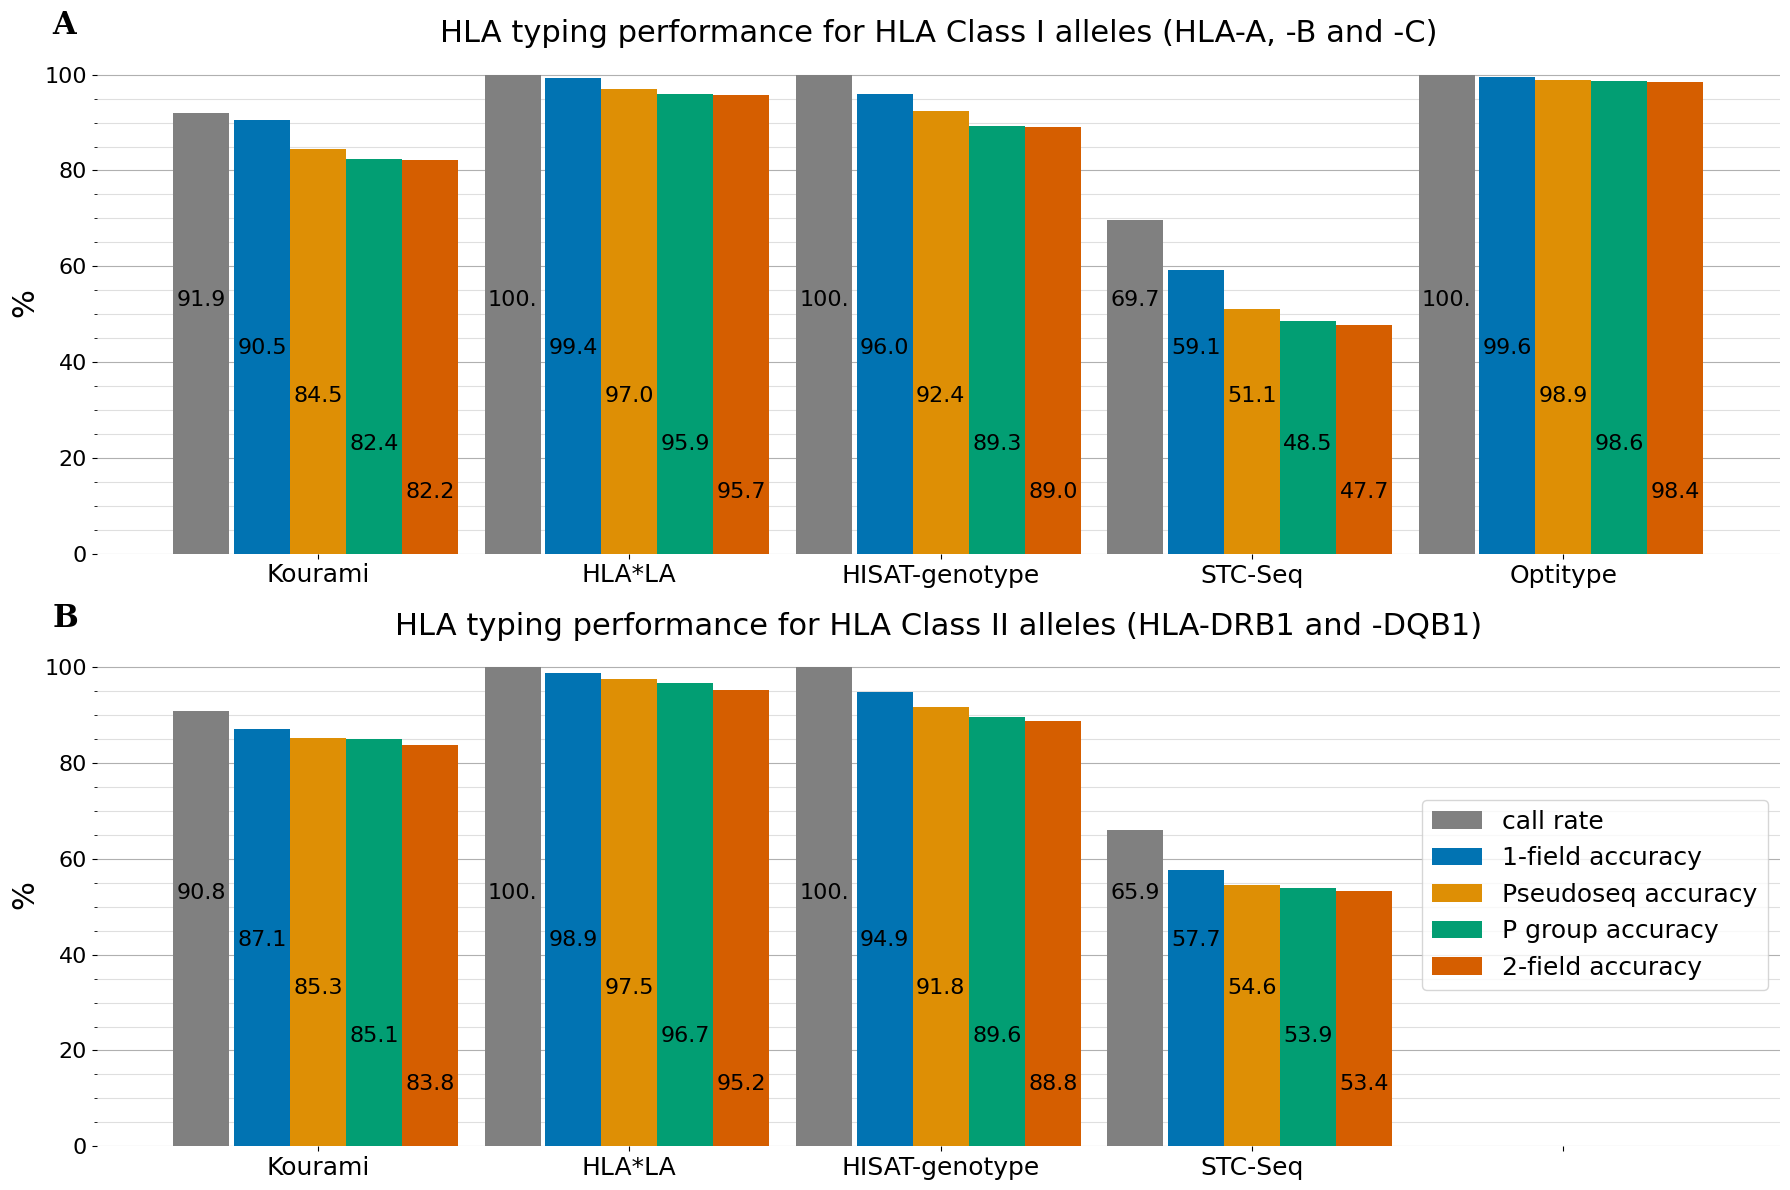

In [31]:
import random

random.shuffle(gold_standard_id_list)

sub_gs_list = gold_standard_id_list[0:len(gold_standard_id_list)//2]

subsample_half_results_dict = dict()
for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
    subsample_half_results_dict[rename_resolutions[resolution]], miscalls_dict = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=sub_gs_list, resolution=resolution)

results_df = reformat_dict(subsample_half_results_dict)

import matplotlib.transforms as mtransforms
palette_list = list(sns.color_palette("colorblind"))
fig = make_plot_from_allele_list()

if subsampling == False:
    fig.savefig('paper_plots/FigureS8.eps', dpi=600)

# Is Optitype biased towards these samples?

In [32]:
optitype_samples_list = list(pd.read_csv('../reference_data/sample_overlap_data/optitype_samples.txt', header=None)[0])
 
optitype_overlap_list = list(set(gold_standard_id_list).intersection(set(optitype_samples_list)))
print(len(optitype_overlap_list))

non_optitype_overlap_list = list(set(gold_standard_id_list) - (set(optitype_samples_list)))
print(len(non_optitype_overlap_list))

95
734


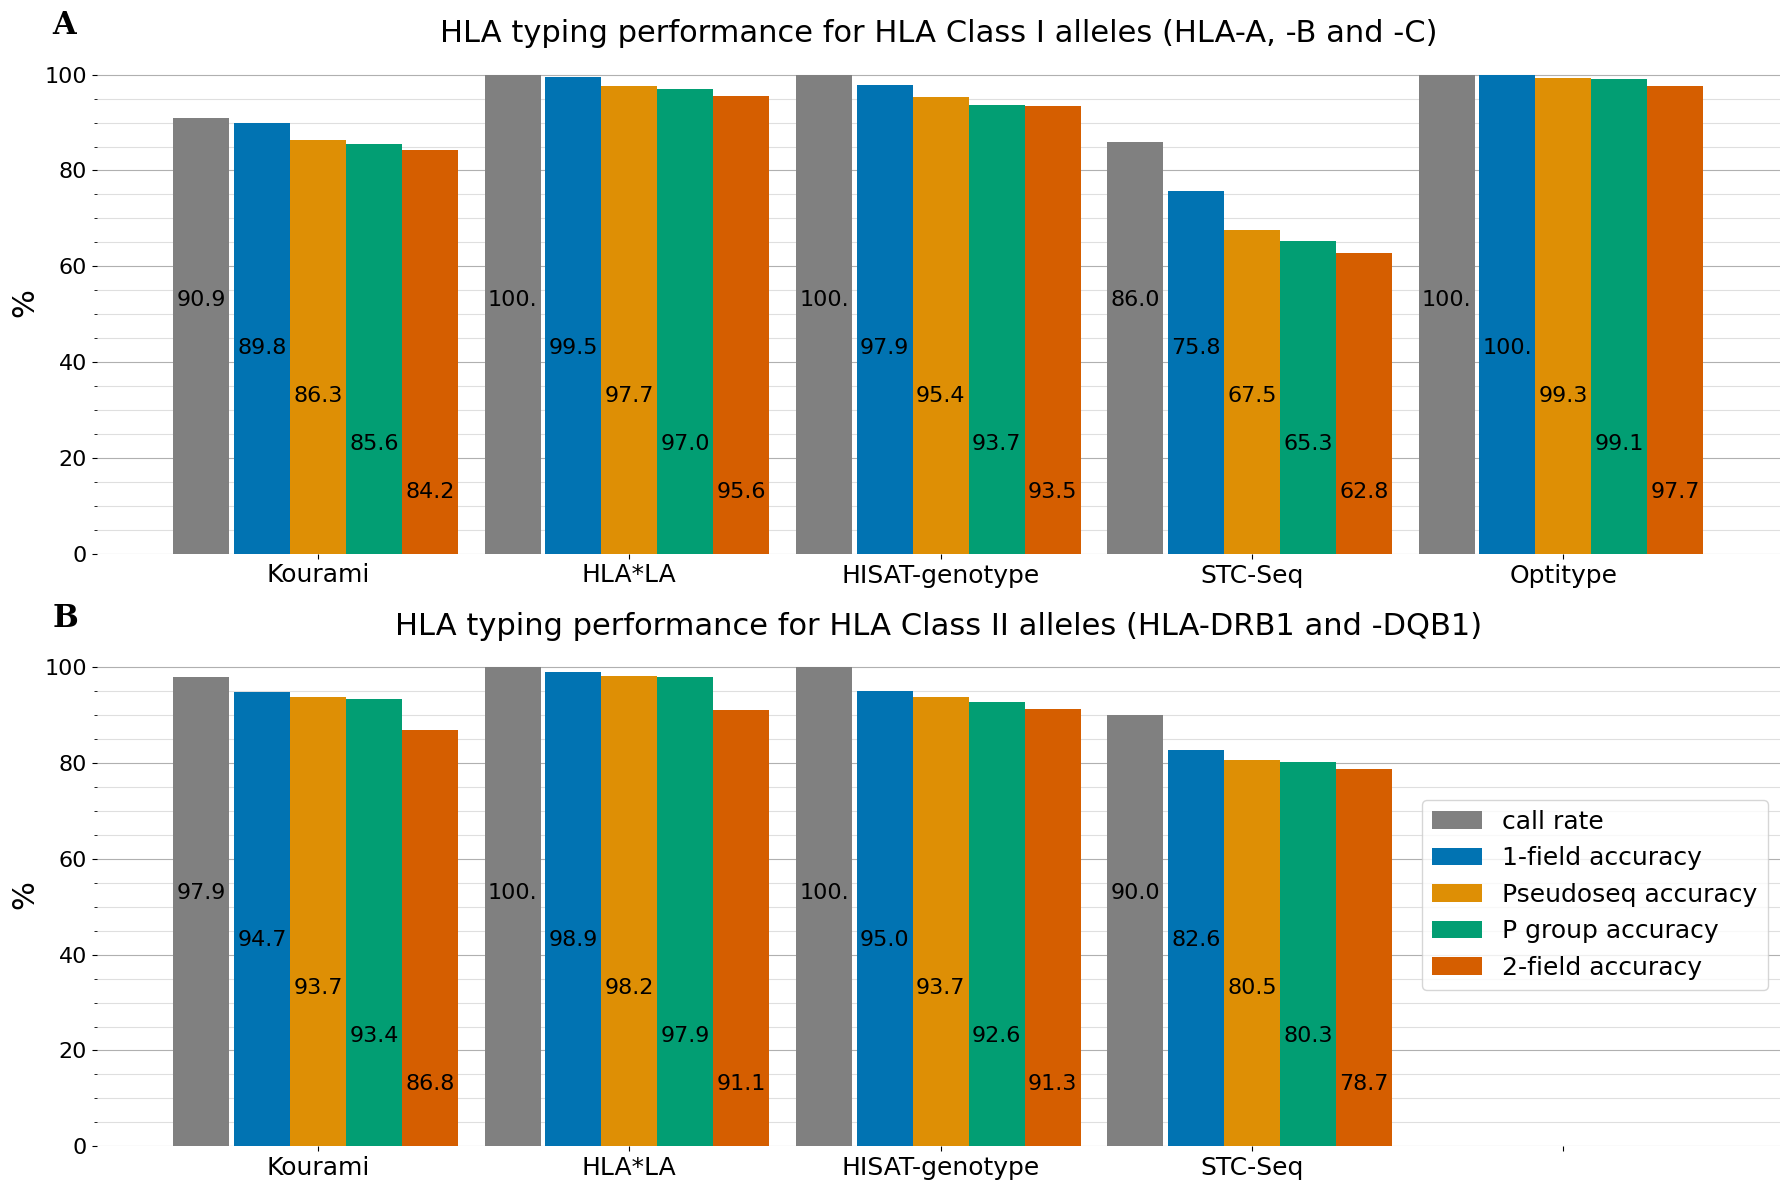

In [33]:
import random


optitype_overlap_results_dict = dict()
for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
    optitype_overlap_results_dict[rename_resolutions[resolution]], miscalls_dict = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=optitype_overlap_list, resolution=resolution)

results_df = reformat_dict(optitype_overlap_results_dict)

import matplotlib.transforms as mtransforms
palette_list = list(sns.color_palette("colorblind"))
fig = make_plot_from_allele_list()


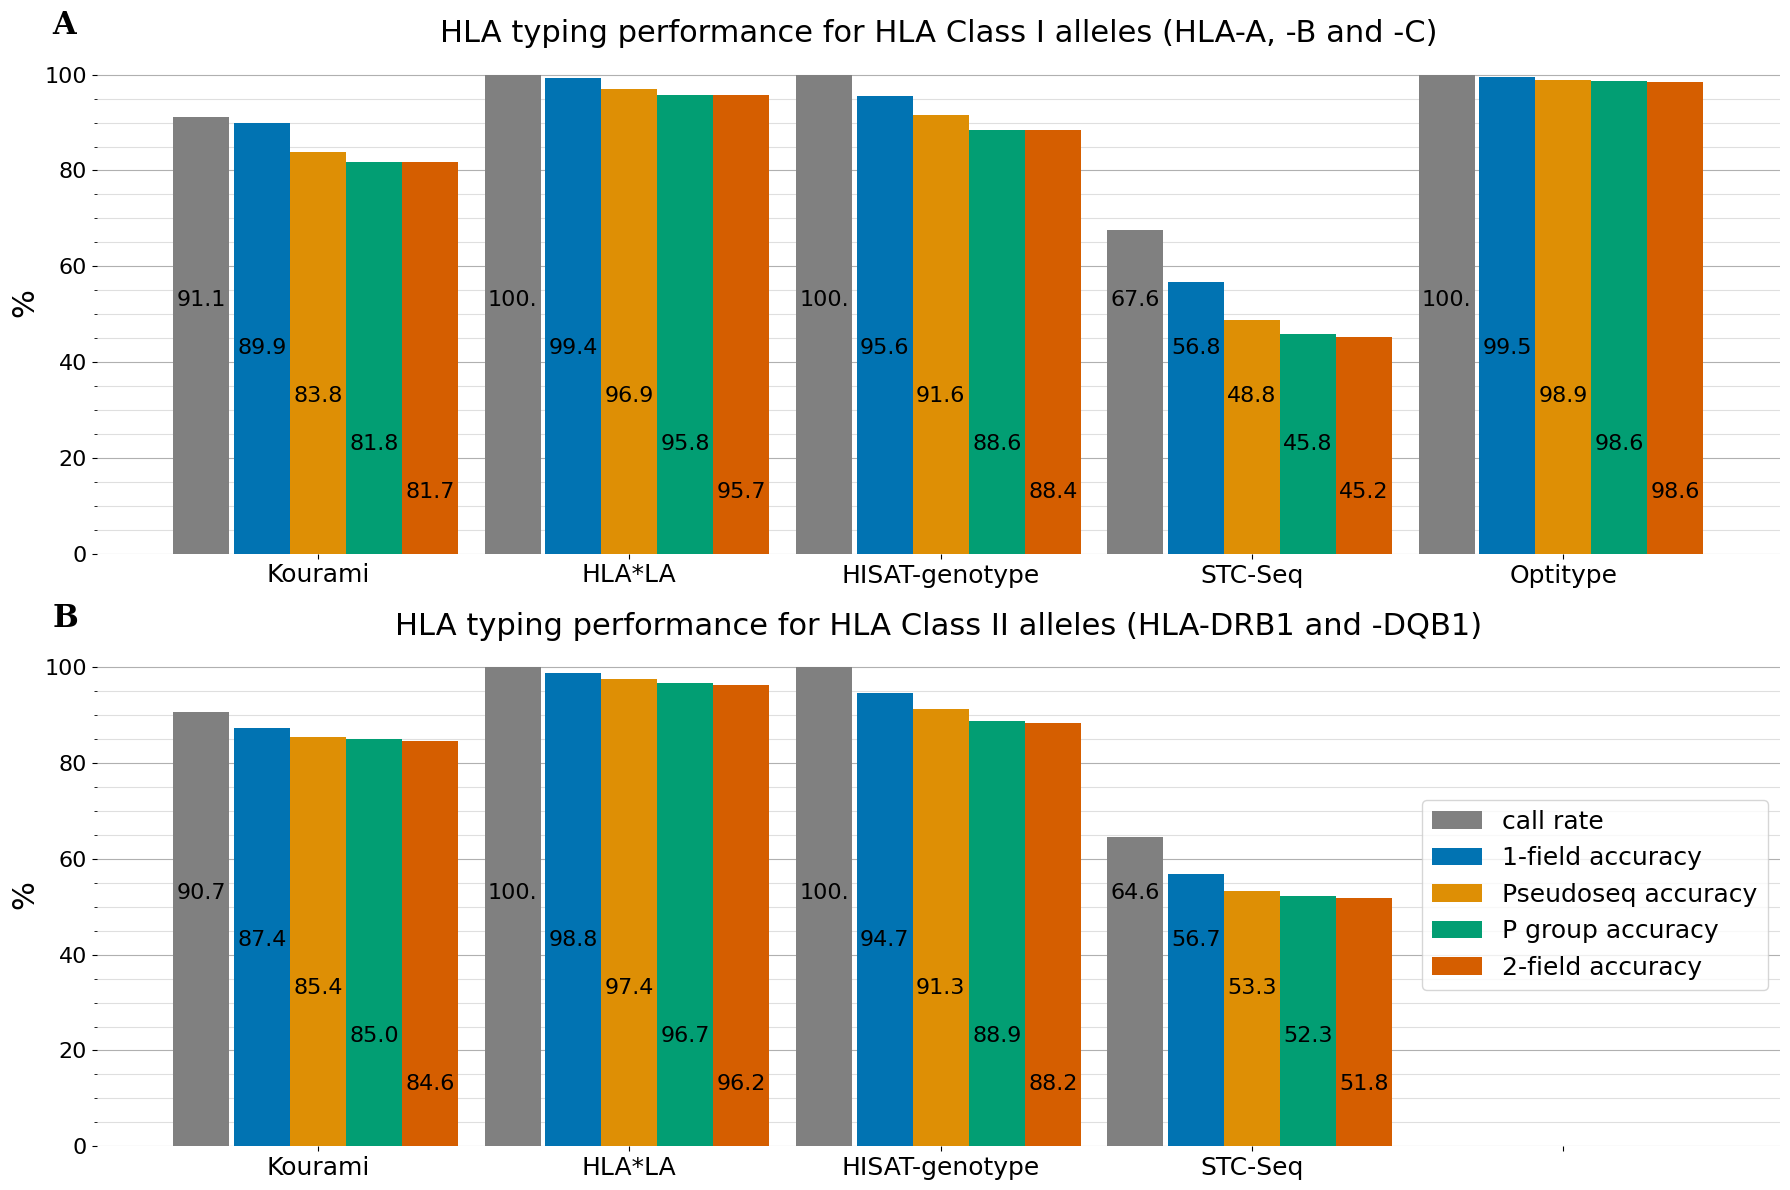

In [34]:
import random


optitype_overlap_results_dict = dict()
for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
    optitype_overlap_results_dict[rename_resolutions[resolution]], miscalls_dict = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=non_optitype_overlap_list, resolution=resolution)

results_df = reformat_dict(optitype_overlap_results_dict)

import matplotlib.transforms as mtransforms
palette_list = list(sns.color_palette("colorblind"))
fig = make_plot_from_allele_list()
